## **Pyro** - вероятностное программирование с pytorch


Нам нужен будет пакет pyro.

In [ ]:
%!pip install pyro-ppl

In [87]:
import logging
import os
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [88]:
smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format="%(message)s", level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use("default")

## Распределение в pytorch

Распределения в Pyro - wrapper для распределений в pytorch, потому что нам хочется дифференцировать автоматически и работать с тензорами, причем делать это быстро с помощью возможностей pytorch.

In [89]:
loc = 0.0  # mean zero
scale = 1.0  # unit standard deviation

In [90]:
# create a normal distribution object in torch
normal = torch.distributions.Normal(loc, scale)

In [91]:
# with rsample it is possible to propagate through random variables
# in a computational graph
x = normal.rsample()  # draw a sample from N(0, 1)

print("sample", x)
print("log prob", normal.log_prob(x))  # score the sample from N(0, 1)

sample tensor(0.6614)
log prob tensor(-1.1376)


## Распределение в pyro

Обратите внимание, что теперь у каждого распределения есть название. Бэкэнд Pyro использует эти имена для уникальной идентификации состояния и изменения сэмплов.

In [92]:
loc = torch.tensor(1.0, requires_grad=True)
scale = torch.tensor(2.0, requires_grad=True)

x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print("x = {:.4}".format(x.item()))

x = 1.534


## Сложное распределение в pyro

In [93]:
def weather(p):
    cloudy = pyro.sample("cloudy", pyro.distributions.Bernoulli(p))
    cloudy = "cloudy" if cloudy.item() == 1.0 else "sunny"
    mean_temp = {"cloudy": 15.0, "sunny": 25.0}[cloudy]
    scale_temp = {"cloudy": 15.0, "sunny": 10.0}[cloudy]
    temp = pyro.sample("temp", pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp


for _ in range(3):
    print(weather(0.5))

('cloudy', tensor(11.7786))
('cloudy', tensor(17.3756))
('sunny', tensor(28.5057))


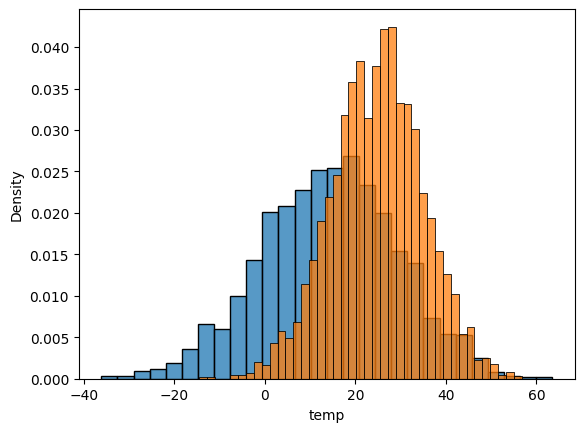

In [94]:
x = np.array(
    [[x[0] == "sunny", x[1].item()] for _ in range(5000) for x in [weather(0.3)]]
)
sns.histplot(x[:, 1][x[:, 0] == 0], stat="density")
sns.histplot(x[:, 1][x[:, 0] == 1], stat="density", color="tab:orange")
plt.xlabel("temp")
plt.show()

## Упражнение:

Написать реализацию распределения Стьюдента (по определению) на pyro:

Определение: распределение Стьюдента c n степенями свободы - t(n):

$$
Y_0, Y_1, ..., Y_n - \text{i.i.d}\; \mathcal{N}(0,1)\\
T = \frac{Y_0}{\sqrt{\frac{1}{n}\sum_{i=1}^{n}Y_i^2}} \sim t(n)
$$

In [95]:
def student(n):
    """
    * n - количество степеней свободы
    """
    samples = torch.tensor(
        [
            pyro.sample("sample_{i}", pyro.distributions.Normal(0, 1))
            for i in range(n + 1)
        ]
    )
    return samples[0] / (torch.mean(samples[1:] ** 2)) ** 0.5

In [96]:
student(6)

tensor(-2.5575)

<AxesSubplot:ylabel='Density'>

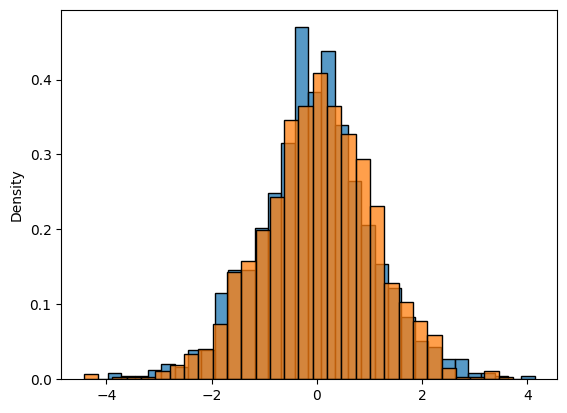

In [97]:
import scipy.stats as stats

my_student = [student(10).item() for _ in range(1000)]
np_student = np.random.standard_t(10, 1000)
sns.histplot(my_student, stat="density")
sns.histplot(np_student, stat="density", color="tab:orange")

## Пример

Рассмотрим более сложный пример. Рассмотрим весы с шумом (noisy scale). Не путайте scale (масштаб) в нормальном распределение и scale (весы) в нашем примере. 

In [98]:
def scale(guess):
    """
    Мы определеяем один параметр:
    * guess - априорное предположение о весе

    Далее задаем вероятностную модель:
    * weight - какой вес получился
    * measurement - как мы его измерили
    """
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

**Вопрос**: Какая вероятностная модель получилась?

$$
\text{weight | guess} ∼ \mathcal{N}(\text{guess}, 1)
$$

$$
\text{measurement | guess, weight} ∼ \mathcal{N}(\text{weight}, 0.75)
$$

## Получение условных вероятностей

Теперь мы начинаем использовать имена наших переменных.

In [107]:
conditioned_scale = pyro.condition(scale, data={"weight": 7})

guess = 2
print(f"guess: {guess}, measurement: {conditioned_scale(guess).item()}")

guess = 20
print(f"guess: {guess}, measurement: {conditioned_scale(guess).item()}")

guess: 2, measurement: 7.105703353881836
guess: 20, measurement: 8.329373359680176


Рассмотрим теперь более интересный случай. Где мы знаем значение итогого измерения measurement. И хотим найти апостериорное распределение веса weight.

In [108]:
measurement_value = torch.tensor(9.5)  # Tensor
conditioned_scale = pyro.condition(scale, data={"measurement": measurement_value})

Далее нам надо определить как будет искаться апостериорное распределение.

Для этого используется функция которую принято называть **guide**.

In [58]:
def get_conditional_location_scale(guess, measurement, measurement_variance):
    loc = (measurement_variance**2 * guess + measurement) / (
        1 + measurement_variance**2
    )
    scale = np.sqrt(measurement_variance**2 / (1 + measurement_variance**2))
    return loc, scale

In [110]:
guess = 8.5
loc, w_scale = get_conditional_location_scale(guess, 9.5, 0.75)
loc, w_scale

(42.08, 0.6)

In [60]:
def perfect_guide(guess, measurement=9.5, measurement_variance=0.75):
    loc, scale = get_conditional_location_scale(
        guess, measurement, measurement_variance
    )
    return pyro.sample("weight", dist.Normal(loc, scale))

## Байесовский вывод

Предположим, что мы не можем выразить апостериорное распределение аналитически.

Попробуем оценить апостериорное распределение с помощью pyro и вычислительных методов.
Для этого зададим параметрическое семейство в качестве апостериорного и будем оценивать параметры этого распределения.

В качестве параметрического семейства выберем нормальное распределение N(a,b).

In [61]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.0), constraint=constraints.positive)  # <--
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

Реализуем теперь поиск апостериорных параметров с помощью стохастического вариационного вывода (SVI).

In [112]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned_scale,
    guide=scale_parametrized_guide,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)

In [113]:
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

a =  9.178815841674805
b =  0.6082875728607178


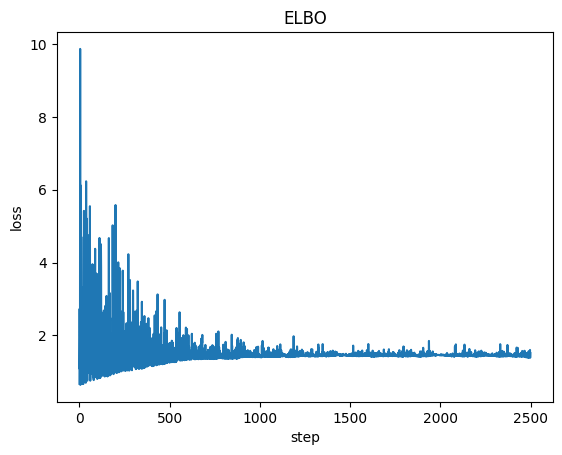

In [114]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print("a = ", pyro.param("a").item())
print("b = ", pyro.param("b").item())

In [115]:
loc, w_scale = get_conditional_location_scale(guess, 9.5, 0.75)

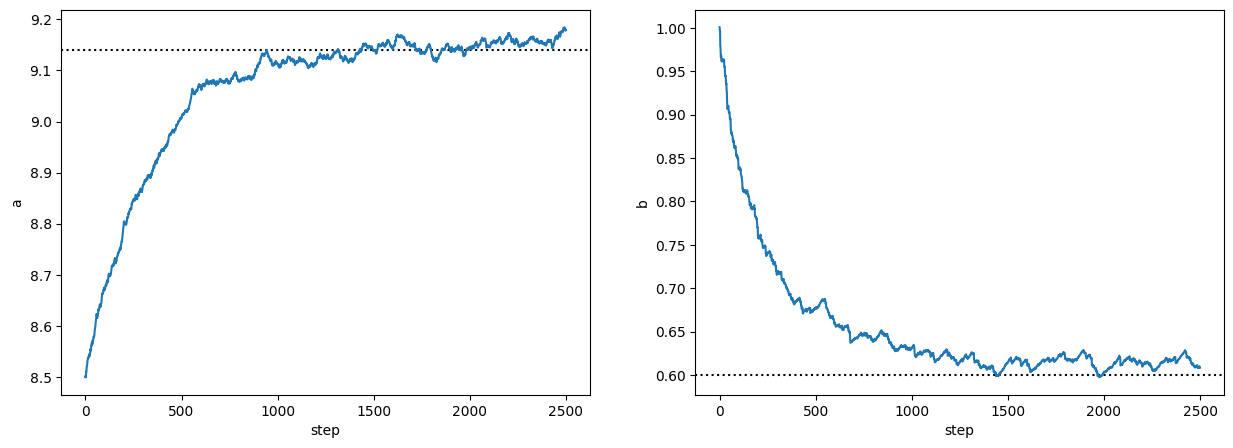

In [116]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xlabel("step")
plt.ylabel("a")
plt.axhline(loc, ls=":", c="black")
plt.plot(a)


plt.subplot(1, 2, 2)
plt.xlabel("step")
plt.ylabel("b")
plt.axhline(w_scale, ls=":", c="black")
plt.plot(b)

plt.show()

## Упражнение:

Написать процедуру Байесовского вывода для более сложной, аналитически не вычислимой модели.

Рассмотрим предыдущую задачу, но изменим следующее распределение:

$$
\text{weight | guess} ∼ \mathcal{N}(\text{guess}, 1)
$$

$$
\text{measurement | guess, weight} ∼ \mathcal{N}\color{red}{(f(}\text{weight}\color{red}{)},  0.75)
$$

При этом $f(\cdot)$ является нелинейной функцией.

Пусть $f(x) = \sqrt x$<br>
Найдите параметры апостериорного распределения weight при заданных<br>
guess = 8.5<br>
measurement = 4.0<br>

In [134]:
# ваш код


def scale_sqrt(guess):
    """
    Мы определеяем один параметр:
    * guess - априорное предположение о весе

    Далее задаем вероятностную модель:
    * weight - какой вес получился
    * measurement - как мы его измерили
    """
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))  # z - latent variable
    return pyro.sample("measurement", dist.Normal((torch.abs(weight)) ** 0.5, 0.75))

In [135]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.0), constraint=constraints.positive)  # <--
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

In [136]:
conditioned_scale_sqrt = pyro.condition(
    scale_sqrt, data={"measurement": torch.tensor(4.0)}
)

In [137]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned_scale_sqrt,
    guide=scale_parametrized_guide,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)

In [138]:
losses, a, b = [], [], []
num_steps = 5000
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

a =  8.829092025756836
b =  0.9606320261955261


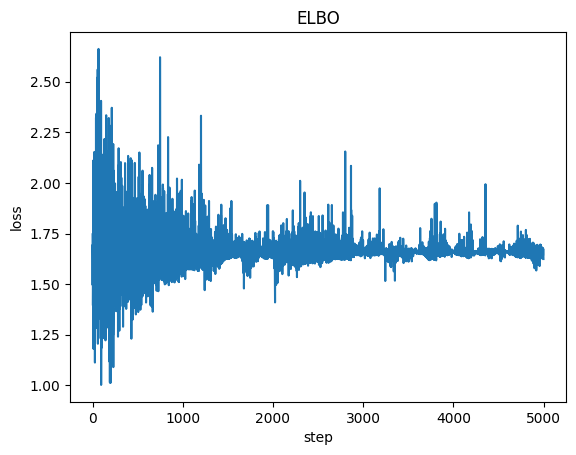

In [139]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print("a = ", pyro.param("a").item())
print("b = ", pyro.param("b").item())

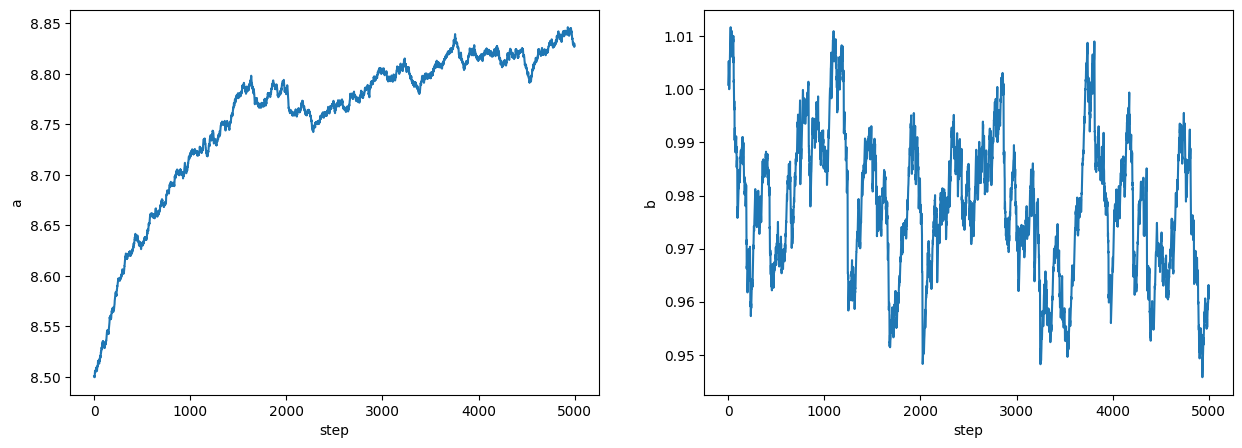

In [140]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xlabel("step")
plt.ylabel("a")
plt.plot(a)


plt.subplot(1, 2, 2)
plt.xlabel("step")
plt.ylabel("b")
plt.plot(b)

plt.show()

## Байесовское моделирование с Pyro. Практический пример

## Загрузка данных

In [141]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

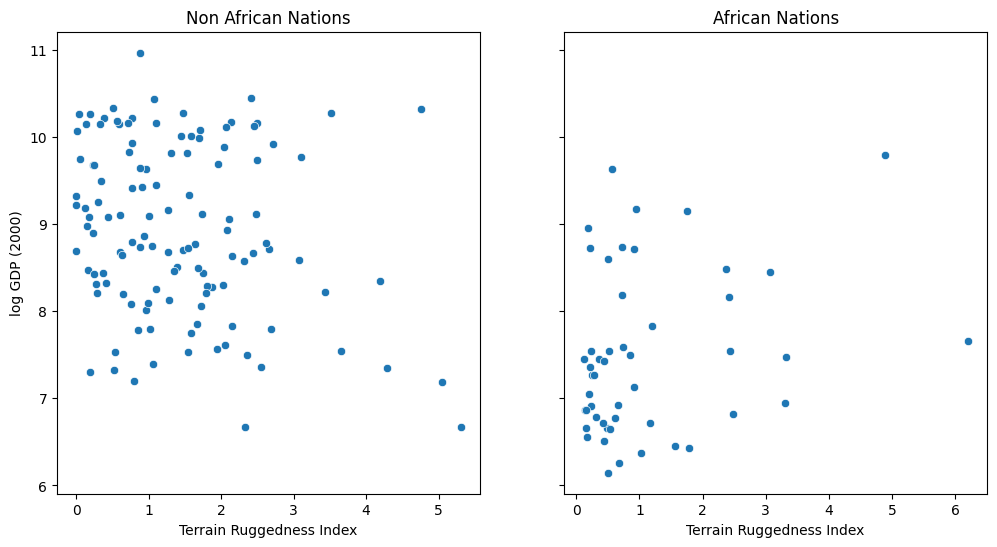

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(
    x=non_african_nations["rugged"], y=non_african_nations["rgdppc_2000"], ax=ax[0]
)
ax[0].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="Non African Nations",
)
sns.scatterplot(x=african_nations["rugged"], y=african_nations["rgdppc_2000"], ax=ax[1])
ax[1].set(
    xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations"
);

## Модели в Pyro

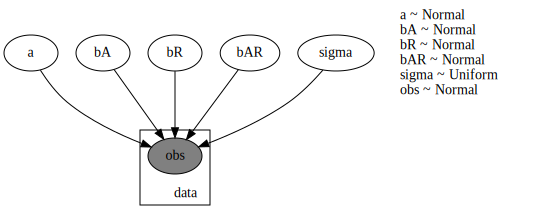

In [143]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0.0, 10.0))
    b_a = pyro.sample("bA", dist.Normal(0.0, 1.0))
    b_r = pyro.sample("bR", dist.Normal(0.0, 1.0))
    b_ar = pyro.sample("bAR", dist.Normal(0.0, 1.0))
    sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0))

    mean = (
        a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    )

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)


pyro.render_model(
    model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True
)

## Вариационный вывод

In [144]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param("a_loc", lambda: torch.tensor(0.0))
    a_scale = pyro.param(
        "a_scale", lambda: torch.tensor(1.0), constraint=constraints.positive
    )
    sigma_loc = pyro.param(
        "sigma_loc", lambda: torch.tensor(1.0), constraint=constraints.positive
    )
    weights_loc = pyro.param("weights_loc", lambda: torch.randn(3))
    weights_scale = pyro.param(
        "weights_scale", lambda: torch.ones(3), constraint=constraints.positive
    )
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

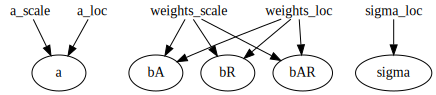

In [146]:
pyro.render_model(
    custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True
)

In [147]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

In [148]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()

Elbo loss: 693.0608777403831


Elbo loss: 539.4902793169022
Elbo loss: 469.64551717042923
Elbo loss: 399.67831736803055
Elbo loss: 322.7295029759407
Elbo loss: 256.04217678308487
Elbo loss: 247.8130522966385
Elbo loss: 247.91180646419525
Elbo loss: 249.15535140037537
Elbo loss: 248.82401233911514


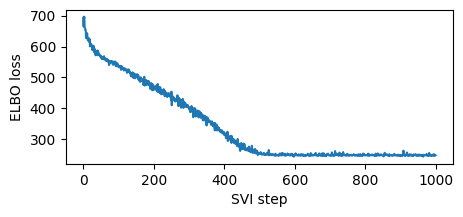

In [149]:
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [150]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.195196
AutoNormal.scales.a 0.07207437
AutoNormal.locs.bA -1.8650632
AutoNormal.scales.bA 0.12992722
AutoNormal.locs.bR -0.17131542
AutoNormal.scales.bR 0.037009556
AutoNormal.locs.bAR 0.33116886
AutoNormal.scales.bAR 0.08162226
AutoNormal.locs.sigma -2.2046947
AutoNormal.scales.sigma 0.05912682


In [151]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

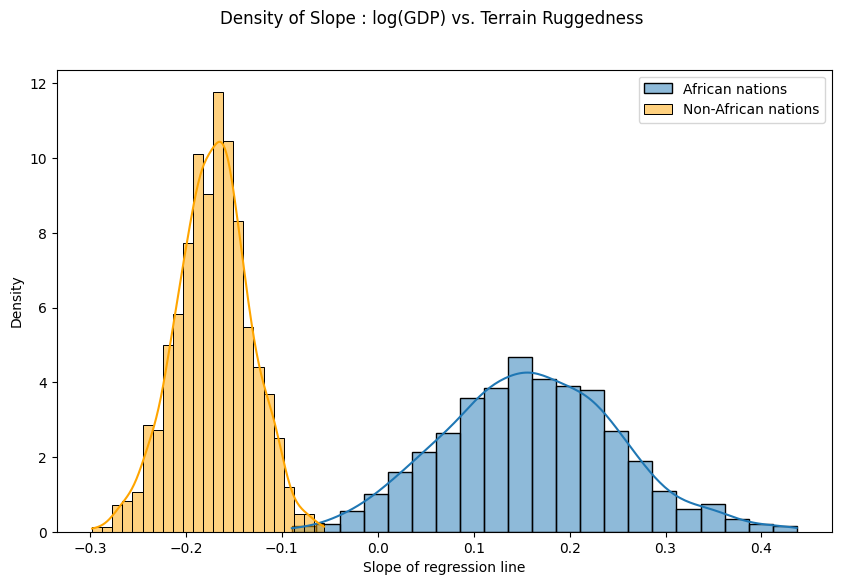

In [152]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(
    gamma_within_africa.detach().cpu().numpy(),
    kde=True,
    stat="density",
    label="African nations",
)
sns.histplot(
    gamma_outside_africa.detach().cpu().numpy(),
    kde=True,
    stat="density",
    label="Non-African nations",
    color="orange",
)
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

## Предсказания модели

In [153]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

In [154]:
svi_gdp.shape

torch.Size([800, 170])

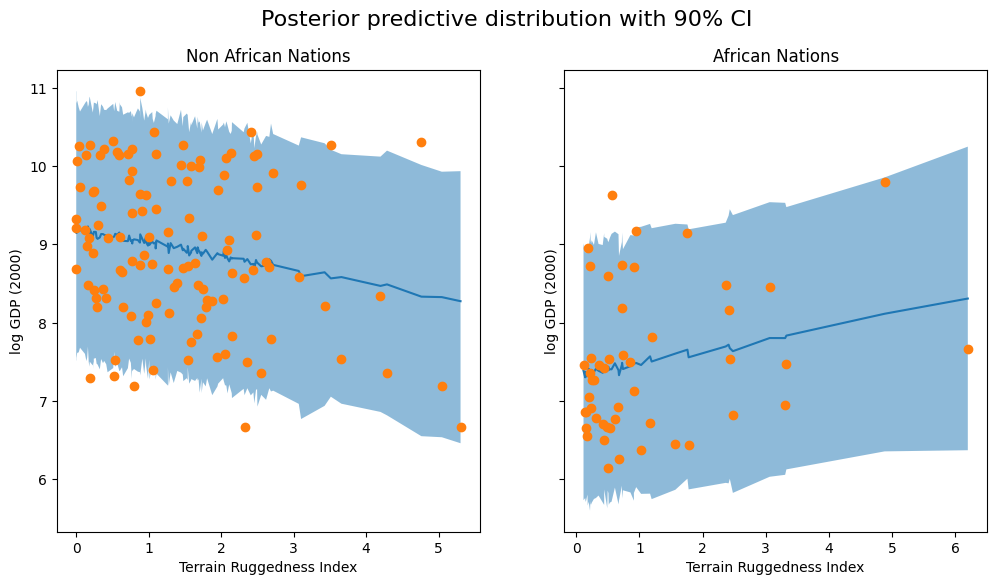

In [155]:
predictions = pd.DataFrame(
    {
        "cont_africa": is_cont_africa,
        "rugged": ruggedness,
        "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
        "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0]
        .detach()
        .cpu()
        .numpy(),
        "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0]
        .detach()
        .cpu()
        .numpy(),
        "true_gdp": log_gdp,
    }
)
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(
    by=["rugged"]
)
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(
    by=["rugged"]
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(
    non_african_nations["rugged"],
    non_african_nations["y_perc_5"],
    non_african_nations["y_perc_95"],
    alpha=0.5,
)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="Non African Nations",
)

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(
    african_nations["rugged"],
    african_nations["y_perc_5"],
    african_nations["y_perc_95"],
    alpha=0.5,
)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(
    xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations"
);